In [1]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import Room_generator as room
import pyroomacoustics as pyra
from tqdm import tqdm
from scipy.signal import correlate
from scipy.signal import convolve
%matplotlib inline

In [2]:
[fs, orig] = wav.read('can-one-hear-anechoic-normal.wav')
from IPython.display import Audio
orig_trunc = orig
Audio(orig_trunc , rate=fs)

C-extension libroom unavailable. Falling back to pure python
C-extension libroom unavailable. Falling back to pure python
C-extension libroom unavailable. Falling back to pure python
C-extension libroom unavailable. Falling back to pure python


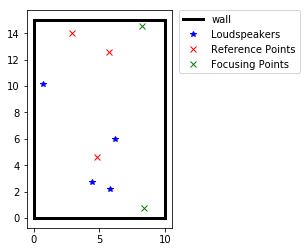

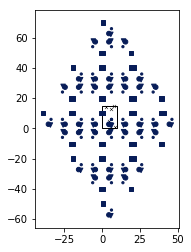

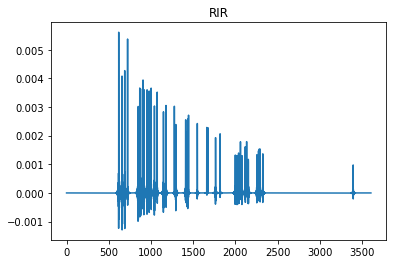

In [3]:
# setting up for the room geometry
room_wid = 10
room_len = 15

n_speaker = 4 # number of speakers
num_focus_points = 2 # number of focusing points

# Setting up for the focusing points
focus_points = np.empty((num_focus_points,),dtype=object)
for i in range(num_focus_points):
    focus_points[i] = np.multiply(np.random.rand(1,2), np.array([room_wid,room_len]))

# Setting up for the referencing points
num_ref_points = 3 # number of reference points against the focusing point
ref_points = np.empty((num_ref_points,),dtype=object)
for i in range(num_ref_points):
    ref_points[i] = np.multiply(np.random.rand(1,2), np.array([room_wid,room_len]))

speaker_loc = room.room_generate(room_wid, room_len, n_speaker, focus_points, ref_points)
# plt.show() # Plotting out the room geometry and the overall setting

# Obatining the RIR for the room
room = pyra.ShoeBox([room_wid, room_len], fs=16000, max_order=4)

# Adding in the loudspeakers' locations to the room
for i in range(n_speaker):
    room.add_source(speaker_loc[i])

# Adding in the microphones' locations to the room
mics_points_matrix = np.empty((2,num_ref_points + num_focus_points))
for i in range(num_ref_points + num_focus_points):
    if i < num_focus_points:
        mics_points_matrix[:, i] = focus_points[i].flat
    else:
        mics_points_matrix[:, i] = ref_points[i-num_focus_points].flat

mics = pyra.MicrophoneArray(mics_points_matrix, room.fs)
room.add_microphone_array(mics)

# Execute the image source model method for the room
room.image_source_model()

# Calculates the RIR for every source-microphone combinations from the above setting.
# NOTICE: the indexing for the RIR will be that room.rir[mic][source]
room.compute_rir()
RIR = np.array(room.rir) # converting the room.rir (list) to RIR (numpy array)

room.plot(img_order=4)

plt.figure()
plt.plot(RIR[0][0])
plt.title('RIR')
plt.show()

In [4]:
Room_RIR = RIR[0][0] # We are now using only one RIR, which is from the 0th source to the 0th receiver
with_rev = convolve(Room_RIR, orig_trunc)
print(with_rev.shape)

(178318,)


In [5]:
Audio(with_rev , rate=fs)

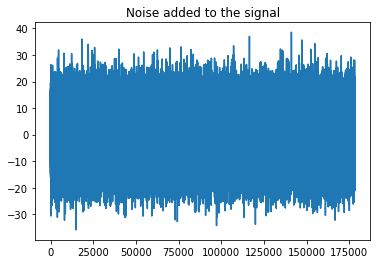

In [6]:
# Now to add in a gaussien distributed noise of a specified SNR

Desired_SNR = 20 # Desired SNR specified by the user

def get_noise(x, SNR):
    # x is our original signal, and SNR is specified by the user
    N = len(x)
    rand_noise = np.random.normal(0, 1000 , N)
    noise_power = np.dot(abs(rand_noise) , abs(rand_noise)) / N
    signal_power = np.dot(abs(x) , abs(x)) / N
    
    k = (signal_power/noise_power)*(10**(-SNR/10))
    
    final_noise = rand_noise * np.sqrt(k)
        
    return final_noise

noise = get_noise(with_rev , Desired_SNR)

with_rev_noisy = with_rev + noise
    
plt.figure()
plt.plot(noise)
plt.title('Noise added to the signal')
plt.show()
    

In [7]:
Audio(with_rev_noisy , rate=fs)

In [8]:
# Conj gradient method
# Here we have a system that is Ax = b where A is the convolution matrix derived from the RIR
# In order to use the conj gradient method, we need it to be symmetric and positive definite
# Therefore, we are actually solving for the system (A^T)Ax = (A^T)b

# Obtaining the modified b = (A^T)b
mod_b = correlate(with_rev_noisy, Room_RIR, mode='valid')
print(mod_b.shape)

(174713,)


In [9]:
N = 10 # Assuming we are only using N vectors for the conjugate basis. The number should be specified by the user

# P = np.empty((N,),dtype=object) # Initialize Conjugate basis
# alpha = np.zeros((N,)) + 0.0j # Initialize the coefficients for the basis
# res = np.empty((N,),dtype=object) # Initialize the residuals for each step
# x_hat = np.empty((N,),dtype=object) # Initialize estimated x

# Starting for the initial guess x_0 = [ 0 0 0 0 0 0 ......0]
x_hat = np.zeros(orig_trunc.shape)
res = mod_b - correlate(convolve(Room_RIR, x_hat), Room_RIR, mode='valid')
P = res
k = 0

# Now start the for loop to find the other vectors in the basis
for n in tqdm(range(N-1)):
    alpha = np.inner(res,res)/np.inner(convolve(Room_RIR, P), convolve(Room_RIR, P))
    x_hat = x_hat + alpha*P 
    res_prev = res
    res = res - alpha*correlate(convolve(Room_RIR, P), Room_RIR, mode='valid')
    beta = np.inner(res,res) / np.inner(res_prev,res_prev)
    P = res + beta*P

100%|██████████| 9/9 [00:00<00:00, 12.38it/s]


In [10]:
print('The 2-norm square for the final residual || (A^T)b - (A^T)Ax_est ||^2= %f' % np.inner(res,res))
error = orig_trunc - x_hat

The 2-norm square for the final residual || (A^T)b - (A^T)Ax_est ||^2= 10164.218203


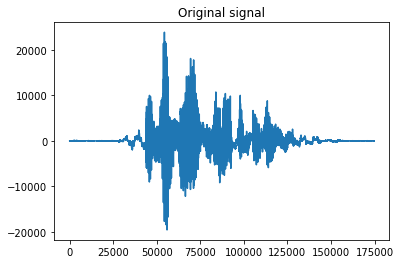

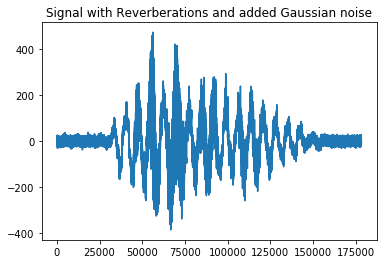

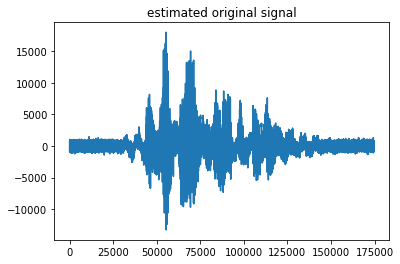

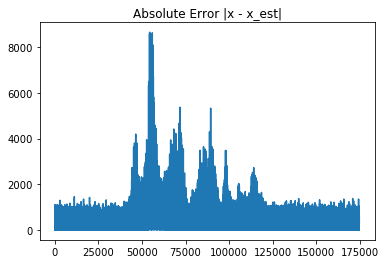

In [13]:
plt.figure()
plt.plot(orig_trunc)
plt.title('Original signal')
plt.figure()
plt.plot(with_rev_noisy)
plt.title('Signal with Reverberations and added Gaussian noise')
plt.figure()
plt.plot(x_hat)
plt.title('estimated original signal')
plt.figure()
plt.plot(abs(error))
plt.title('Absolute Error |x - x_est|')
plt.show()

In [14]:
Audio(x_hat , rate=fs)